### Add tuning

# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.04]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(\bar{x_t}^T\theta_{t,a})$. Here $\bar{x_t}$ is not context observed at time t, but rather it is expected context inside one stationarity interval.  Also $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  For each arm $a_i$, parameter $\theta_{t,a}$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(\bar{x_t}^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 5
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [-1, 0, 1, 2],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [-1, 1],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [-1, 0, 1],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [-2, -1, 0, 1],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [-2, -1, 0, 1, 2],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [-1, 0, 1, 2],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[ 2.,  1.,  0.,  1.,  1.],
        [ 2.,  1., -1.,  0.,  1.],
        [ 2., -1., -1.,  0.,  2.],
        ...,
        [ 0.,  1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.,  0.],
        [ 0.,  1., -1.,  1.,  2.]]),
 (10000, 5))

### Visualizing context features

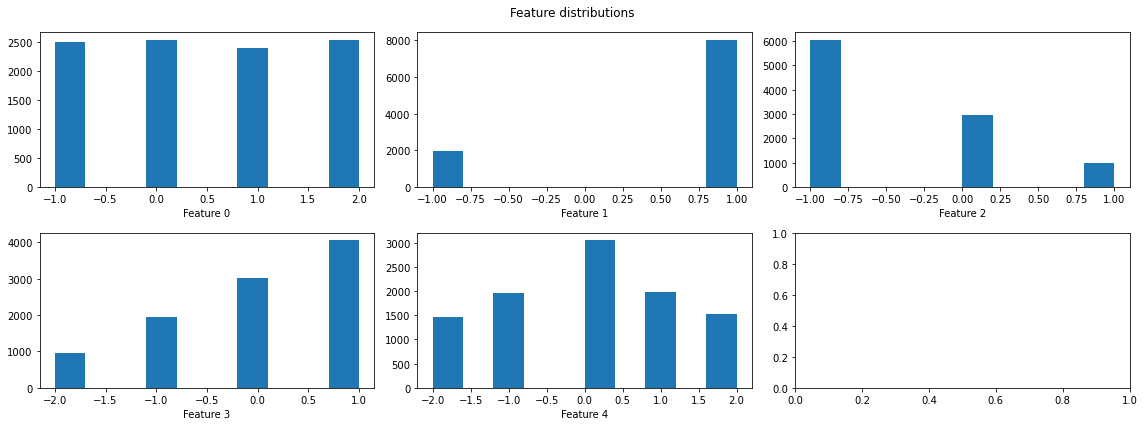

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval [0, 0.05] 
interval_means = [np.random.uniform(0, 0.03, size=(NUM_FEATURES,)) for i in range(5)]

In [12]:
# Fixed std
interval_stds = [[0.0005]*NUM_FEATURES]*5

In [13]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

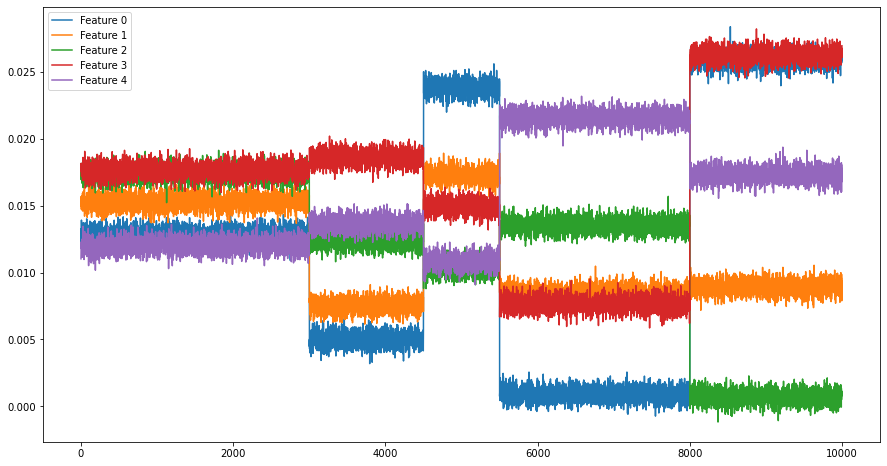

In [14]:
plot_costs(get_costs(), 10000)

In [15]:
costs_obj = get_costs()

In [16]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [17]:
costs_vector.shape

(10000, 5)

## Creating rewards

In [18]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [19]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [20]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [21]:
mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        
        random_vec = np.random.normal(size=NUM_FEATURES)
        theta = random_vec / np.linalg.norm(random_vec)

        expected_context = np.mean(context_slice, axis=0)
        
        z = context_slice @ theta
        
        p = np.where(z > 0.5, 1, 0)
        
        slice_rewards = np.where(z > 0.5, 1, 0)
        

        # Sample rewards from the obtained distribution.
#         slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.43, mean reward=0.43   reward estimated by linear regression 0.31
  Arm 1: p=0.34, mean reward=0.34   reward estimated by linear regression 0.22
  Arm 2: p=0.49, mean reward=0.49   reward estimated by linear regression 0.35
  Arm 3: p=0.48, mean reward=0.48   reward estimated by linear regression 0.34
  Arm 4: p=0.35, mean reward=0.35   reward estimated by linear regression 0.23
Slice 1:
  Arm 0: p=0.48, mean reward=0.48   reward estimated by linear regression 0.37
  Arm 1: p=0.44, mean reward=0.44   reward estimated by linear regression 0.33
  Arm 2: p=0.62, mean reward=0.62   reward estimated by linear regression 0.52
  Arm 3: p=0.61, mean reward=0.61   reward estimated by linear regression 0.50
  Arm 4: p=0.21, mean reward=0.21   reward estimated by linear regression 0.08
Slice 2:
  Arm 0: p=0.09, mean reward=0.09   reward estimated by linear regression -0.00
  Arm 1: p=0.43, mean reward=0.43   reward estimated by linear regression 0.31
  Arm 2: p=0.27, mean re

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_24090/1529984788.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

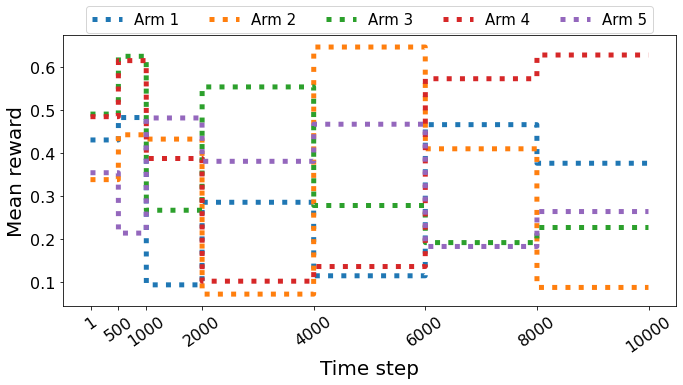

In [22]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000]
plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [23]:
rewards.shape

(10000, 5)

In [24]:
costs_vector.shape

(10000, 5)

## Testing algorithms on synthetic data

In [25]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
NUM_OF_TRIALS = 10000
TUNING_NUM_TRIALS = 3000

### Random policy

#### Evaluation

In [27]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Random policy
Total gain: 3348.0
	Total reward: 3348.0
	Total cost: 0
Execution time: 0.1s


### $\epsilon$-greedy

#### Tuning

In [28]:
egreedy_gains = {}

for eps in [0.001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3]:
    egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Total gain: 846.0
	Total reward: 846.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.005)
Total gain: 1329.0
	Total reward: 1329.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.01)
Total gain: 1108.0
	Total reward: 1108.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.05)
Total gain: 1304.0
	Total reward: 1304.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.08)
Total gain: 1343.0
	Total reward: 1343.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.1)
Total gain: 1148.0
	Total reward: 1148.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.2)
Total gain: 1271.0
	Total reward: 1271.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.3)
Total gain: 1284.0
	Total reward: 1284.0
	Total cost: 0
Execution time: 0.0s


In [29]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [30]:
best_eps

0.08

In [31]:
del egreedy_gains

#### Evaluation

In [32]:
egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

E-greedy(epsilon=0.08)
Total gain: 4731.0
	Total reward: 4731.0
	Total cost: 0
Execution time: 0.1s


### UCB1

#### Tuning

In [33]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    ucb_alg = algorithms.UCB1(
        n_trials=TUNING_NUM_TRIALS,
        n_arms=rewards.shape[1],
        alpha=alpha,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.01)
Total gain: 846.0
	Total reward: 846.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.05)
Total gain: 1207.0
	Total reward: 1207.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.1)
Total gain: 1409.0
	Total reward: 1409.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.15)
Total gain: 1463.0
	Total reward: 1463.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.2)
Total gain: 1467.0
	Total reward: 1467.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.25)
Total gain: 1451.0
	Total reward: 1451.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.3)
Total gain: 1464.0
	Total reward: 1464.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.35)
Total gain: 1438.0
	Total reward: 1438.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.4)
Total gain: 1466.0
	Total reward: 1466.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.45)
Total gain: 1473.0
	Total reward: 1473.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.5)
Total gain: 1493.0
	Total reward: 1493.0
	Total cost: 0
Execution time: 0.0s


In [34]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [35]:
best_alpha_ucb

0.5

In [36]:
del ucb_gains

#### Evaluation

In [37]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=best_alpha_ucb,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

UCB1 (α=0.5)
Total gain: 5401.0
	Total reward: 5401.0
	Total cost: 0
Execution time: 0.1s


### LinUCB

#### Tuning

In [38]:
linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    linucb = algorithms.LinUCB(
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=alpha,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.1)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.2)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.3)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.4)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.5)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.6)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	Total cost: 225.43754566803395
Execution time: 0.1s
LinUCB (alpha=0.7)
Total gain: 1294.5624543319666
	Total reward: 1520.0
	Total cost: 225.43754566803395
Execution time: 0.1s


In [39]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [40]:
best_alpha_linucb

0.3

In [41]:
del linucb_gains

#### Evaluation

In [42]:
linucb = algorithms.LinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_linucb,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

LinUCB (alpha=0.3)
Total gain: 5057.458849085224
	Total reward: 5734.0
	Total cost: 676.5411509148023
Execution time: 0.3s


### PS-LinUCB

#### Tuning

In [43]:
ps_linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for omega in [300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            ps_linucb = algorithms.PSLinUCB(
                context_dimension=contexts.shape[1],
                n_arms=rewards.shape[1],
                alpha=alpha,
                omega=omega,
                delta=delta,
            )


            gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                ps_linucb,
                contexts,
                rewards,
                costs_vector,
                stop_after=TUNING_NUM_TRIALS,
            )
            
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.1, omega=300, delta=0.001)
Total gain: 1325.5624543319664
	Total reward: 1551.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=300, delta=0.005)
Total gain: 1325.5624543319664
	Total reward: 1551.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=300, delta=0.01)
Total gain: 1325.5624543319664
	Total reward: 1551.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=300, delta=0.03)
Total gain: 1322.5624543319664
	Total reward: 1548.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Total gain: 1321.5624543319664
	Total reward: 1547.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Total gain: 1322.5624543319664
	Total reward: 1548.0
	Total cost: 225.43754566803395
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Total gain: 1362.562454331968
	Total reward: 1588.0
	To

PSLinUCB (alpha=0.1, omega=1750, delta=0.2)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.03)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Total gain: 1006.5624543319632
	Total reward: 1232.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.1)
Total gain: 1006.5624543319632
	Total reward: 123

PSLinUCB (alpha=0.2, omega=1500, delta=0.15)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.001)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.01)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.03)
Total gain: 1456.5624543319695
	Total reward: 1682.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.05)
Total gain: 1456.5624543319695
	Total reward: 16

PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1250, delta=0.2)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.005)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.03)
Total gain: 1590.5624543319718
	Total reward: 1816.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.05)
Total gain: 1590.5624543319718
	Total reward: 18

PSLinUCB (alpha=0.4, omega=1000, delta=0.1)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1000, delta=0.15)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1000, delta=0.2)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.001)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.01)
Total gain: 1352.562454331967
	Total reward: 1578.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.03)
Total gain: 1352.562454331967
	Total reward: 1578.0
	To

PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.15)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.2)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.005)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.01)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.03)
Total gain: 1358.562454331968
	Total reward: 1584.0
	Total

PSLinUCB (alpha=0.6, omega=500, delta=0.1)
Total gain: 1255.5624543319664
	Total reward: 1481.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=500, delta=0.15)
Total gain: 1299.5624543319664
	Total reward: 1525.0
	Total cost: 225.43754566803395
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=500, delta=0.2)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	Total cost: 225.43754566803395
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.005)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.01)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Total gain: 1297.5624543319664
	Total reward: 1523.0
	To

PSLinUCB (alpha=0.7, omega=300, delta=0.1)
Total gain: 1284.5624543319661
	Total reward: 1510.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=300, delta=0.15)
Total gain: 1284.5624543319661
	Total reward: 1510.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=300, delta=0.2)
Total gain: 1284.5624543319661
	Total reward: 1510.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=500, delta=0.001)
Total gain: 1269.5624543319666
	Total reward: 1495.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=500, delta=0.005)
Total gain: 1269.5624543319666
	Total reward: 1495.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Total gain: 1269.5624543319666
	Total reward: 1495.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Total gain: 1269.5624543319666
	Total reward: 1495.0
	To

PSLinUCB (alpha=0.7, omega=2000, delta=0.1)
Total gain: 1294.5624543319666
	Total reward: 1520.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Total gain: 1294.5624543319666
	Total reward: 1520.0
	Total cost: 225.43754566803395
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Total gain: 1294.5624543319666
	Total reward: 1520.0
	Total cost: 225.43754566803395
Execution time: 0.1s


In [44]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [45]:
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.3, 2000, 0.2)

In [46]:
del ps_linucb_gains

#### Evaluation

In [47]:
ps_linucb = algorithms.PSLinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_ps_linucb,
    omega=best_omega_ps_linucb,
    delta=best_delta_ps_linucb,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Total gain: 5057.458849085224
	Total reward: 5734.0
	Total cost: 676.5411509148023
Execution time: 0.4s


### SimOOS

#### Tuning

In [48]:
simoos_gains = {}

for beta in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]:
    for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3]:
        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=contexts[:TUNING_NUM_TRIALS], 
            number_of_actions=rewards.shape[1],
            max_no_red_context=contexts.shape[1],
            beta_SimOOS=beta,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                contexts[:TUNING_NUM_TRIALS],
                rewards[:TUNING_NUM_TRIALS],
                costs_vector[:TUNING_NUM_TRIALS],
                stop_after=TUNING_NUM_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")

        simoos_gains[(beta, delta)] = gain_simoos

Took 0.001989126205444336 seconds
Trial 0, time 2022-04-02 23:43:14.037641
Trial 500, time 2022-04-02 23:43:19.776718
Trial 1000, time 2022-04-02 23:43:21.032318
Trial 1500, time 2022-04-02 23:43:21.702851
Trial 2000, time 2022-04-02 23:43:22.379987
Trial 2500, time 2022-04-02 23:43:23.045804
SimOOS (beta=0.001, delta=0.005)
Total gain: 1093.8014976473287
	Total reward: 1095.0
	Total cost: 1.1985023526712129
Execution time: 9.7s
Took 9.677227020263672 seconds
Took 0.00986790657043457 seconds
Trial 0, time 2022-04-02 23:43:23.724776
Trial 500, time 2022-04-02 23:43:28.796149
Trial 1000, time 2022-04-02 23:43:30.703310
Trial 1500, time 2022-04-02 23:43:31.376304
Trial 2000, time 2022-04-02 23:43:32.214948
Trial 2500, time 2022-04-02 23:43:32.888901
SimOOS (beta=0.001, delta=0.01)
Total gain: 1229.8014976473287
	Total reward: 1231.0
	Total cost: 1.1985023526712129
Execution time: 9.7s
Took 9.686791896820068 seconds
Took 0.0019099712371826172 seconds
Trial 0, time 2022-04-02 23:43:33.41350

Trial 500, time 2022-04-02 23:46:12.219438
Trial 1000, time 2022-04-02 23:46:13.315592
Trial 1500, time 2022-04-02 23:46:13.965581
Trial 2000, time 2022-04-02 23:46:14.657837
Trial 2500, time 2022-04-02 23:46:15.367889
SimOOS (beta=0.005, delta=0.12)
Total gain: 1106.8014976473287
	Total reward: 1108.0
	Total cost: 1.1985023526712129
Execution time: 9.5s
Took 9.472631692886353 seconds
Took 0.002062082290649414 seconds
Trial 0, time 2022-04-02 23:46:15.898497
Trial 500, time 2022-04-02 23:46:21.702190
Trial 1000, time 2022-04-02 23:46:22.859823
Trial 1500, time 2022-04-02 23:46:23.560237
Trial 2000, time 2022-04-02 23:46:24.375183
Trial 2500, time 2022-04-02 23:46:25.067445
SimOOS (beta=0.005, delta=0.16)
Total gain: 973.8014976473288
	Total reward: 975.0
	Total cost: 1.1985023526712129
Execution time: 9.7s
Took 9.717338800430298 seconds
Took 0.0018880367279052734 seconds
Trial 0, time 2022-04-02 23:46:25.617757
Trial 500, time 2022-04-02 23:46:31.439287
Trial 1000, time 2022-04-02 23:4

Trial 500, time 2022-04-02 23:51:21.069978
Trial 1000, time 2022-04-02 23:51:24.820223
Trial 1500, time 2022-04-02 23:51:27.241056
Trial 2000, time 2022-04-02 23:51:29.966187
Trial 2500, time 2022-04-02 23:51:31.376500
SimOOS (beta=0.05, delta=0.05)
Total gain: 1191.1652070642367
	Total reward: 1267.0
	Total cost: 75.83479293576222
Execution time: 36.0s
Took 35.98932504653931 seconds
Took 0.0021691322326660156 seconds
Trial 0, time 2022-04-02 23:51:34.476121
Trial 500, time 2022-04-02 23:51:44.767168
Trial 1000, time 2022-04-02 23:51:47.303531
Trial 1500, time 2022-04-02 23:51:48.939288
Trial 2000, time 2022-04-02 23:51:52.061080
Trial 2500, time 2022-04-02 23:51:54.882962
SimOOS (beta=0.05, delta=0.08)
Total gain: 1230.672936501066
	Total reward: 1256.0
	Total cost: 25.327063498933043
Execution time: 21.2s
Took 21.211435079574585 seconds
Took 0.001895904541015625 seconds
Trial 0, time 2022-04-02 23:51:55.689374
Trial 500, time 2022-04-02 23:52:01.681197
Trial 1000, time 2022-04-02 23:

Trial 500, time 2022-04-03 00:06:56.881731
Trial 1000, time 2022-04-03 00:06:59.282757
Trial 1500, time 2022-04-03 00:07:01.418631
Trial 2000, time 2022-04-03 00:07:02.088474
Trial 2500, time 2022-04-03 00:07:15.918551
SimOOS (beta=0.1, delta=0.3)
Total gain: 1328.0706737336825
	Total reward: 1369.0
	Total cost: 40.92932626631688
Execution time: 36.2s
Took 36.1670868396759 seconds
Took 0.00875091552734375 seconds
Trial 0, time 2022-04-03 00:07:22.481780
Trial 500, time 2022-04-03 00:08:28.961967
Trial 1000, time 2022-04-03 00:09:26.100389
Trial 1500, time 2022-04-03 00:10:09.331005
Trial 2000, time 2022-04-03 00:10:41.003042
Trial 2500, time 2022-04-03 00:11:12.972065
SimOOS (beta=0.2, delta=0.005)
Total gain: 1138.8405691056048
	Total reward: 1363.0
	Total cost: 224.15943089439295
Execution time: 4.2m
Took 254.99720978736877 seconds
Took 0.00802302360534668 seconds
Trial 0, time 2022-04-03 00:11:37.487361
Trial 500, time 2022-04-03 00:11:48.756214
Trial 1000, time 2022-04-03 00:11:52.

Trial 500, time 2022-04-03 00:44:55.676819
Trial 1000, time 2022-04-03 00:45:52.731593
Trial 1500, time 2022-04-03 00:46:36.940068
Trial 2000, time 2022-04-03 00:47:09.080956
Trial 2500, time 2022-04-03 00:47:41.297102
SimOOS (beta=0.3, delta=0.1)
Total gain: 1145.443593450051
	Total reward: 1369.0
	Total cost: 223.556406549947
Execution time: 4.3m
Took 257.52943086624146 seconds
Took 0.010436773300170898 seconds
Trial 0, time 2022-04-03 00:48:06.139330
Trial 500, time 2022-04-03 00:48:16.870900
Trial 1000, time 2022-04-03 00:48:19.747332
Trial 1500, time 2022-04-03 00:48:34.141781
Trial 2000, time 2022-04-03 00:49:41.660393
Trial 2500, time 2022-04-03 00:50:35.180510
SimOOS (beta=0.3, delta=0.12)
Total gain: 1133.7803734173833
	Total reward: 1270.0
	Total cost: 136.2196265826165
Execution time: 3.1m
Took 188.1058361530304 seconds
Took 0.0026340484619140625 seconds
Trial 0, time 2022-04-03 00:51:14.246758
Trial 500, time 2022-04-03 00:51:23.988751
Trial 1000, time 2022-04-03 00:51:46.1

Trial 500, time 2022-04-03 01:37:05.297231
Trial 1000, time 2022-04-03 01:37:07.120652
Trial 1500, time 2022-04-03 01:37:10.015542
Trial 2000, time 2022-04-03 01:37:13.125402
Trial 2500, time 2022-04-03 01:37:15.388230
SimOOS (beta=0.5, delta=0.03)
Total gain: 1153.6354405457892
	Total reward: 1187.0
	Total cost: 33.36455945421133
Execution time: 21.9s
Took 21.91940689086914 seconds
Took 0.002115964889526367 seconds
Trial 0, time 2022-04-03 01:37:16.058486
Trial 500, time 2022-04-03 01:37:27.000402
Trial 1000, time 2022-04-03 01:38:17.478731
Trial 1500, time 2022-04-03 01:39:17.505420
Trial 2000, time 2022-04-03 01:39:59.688555
Trial 2500, time 2022-04-03 01:40:42.220743
SimOOS (beta=0.5, delta=0.05)
Total gain: 1331.4017190556372
	Total reward: 1516.0
	Total cost: 184.5982809443651
Execution time: 3.9m
Took 235.61354613304138 seconds
Took 0.002318859100341797 seconds
Trial 0, time 2022-04-03 01:41:11.674462
Trial 500, time 2022-04-03 01:41:22.465778
Trial 1000, time 2022-04-03 01:42:0

Trial 500, time 2022-04-03 02:16:11.185548
Trial 1000, time 2022-04-03 02:16:46.357473
Trial 1500, time 2022-04-03 02:17:51.640976
Trial 2000, time 2022-04-03 02:18:36.336053
Trial 2500, time 2022-04-03 02:19:20.808413
SimOOS (beta=0.6, delta=0.2)
Total gain: 1285.8124784825143
	Total reward: 1463.0
	Total cost: 177.18752151748728
Execution time: 3.9m
Took 231.72584104537964 seconds
Took 0.00824117660522461 seconds
Trial 0, time 2022-04-03 02:19:51.834498
Trial 500, time 2022-04-03 02:20:02.418496
Trial 1000, time 2022-04-03 02:21:02.213271
Trial 1500, time 2022-04-03 02:21:59.772066
Trial 2000, time 2022-04-03 02:22:40.563123
Trial 2500, time 2022-04-03 02:23:22.178909
SimOOS (beta=0.6, delta=0.3)
Total gain: 1324.1434914259014
	Total reward: 1513.0
	Total cost: 188.85650857410064
Execution time: 4.0m
Took 239.2554919719696 seconds
Took 0.0025482177734375 seconds
Trial 0, time 2022-04-03 02:23:51.092581
Trial 500, time 2022-04-03 02:24:01.609727
Trial 1000, time 2022-04-03 02:24:04.02

Trial 500, time 2022-04-03 02:55:58.141956
Trial 1000, time 2022-04-03 02:55:59.977703
Trial 1500, time 2022-04-03 02:56:01.808149
Trial 2000, time 2022-04-03 02:56:04.362638
Trial 2500, time 2022-04-03 02:56:05.912161
SimOOS (beta=0.8, delta=0.09)
Total gain: 1260.1725215026536
	Total reward: 1297.0
	Total cost: 36.82747849734634
Execution time: 18.1s
Took 18.081026077270508 seconds
Took 0.0021512508392333984 seconds
Trial 0, time 2022-04-03 02:56:06.434055
Trial 500, time 2022-04-03 02:56:54.709317
Trial 1000, time 2022-04-03 02:57:19.314697
Trial 1500, time 2022-04-03 02:57:32.792274
Trial 2000, time 2022-04-03 02:57:40.985853
Trial 2500, time 2022-04-03 02:57:46.530520
SimOOS (beta=0.8, delta=0.1)
Total gain: 1109.910991434032
	Total reward: 1296.0
	Total cost: 186.0890085659675
Execution time: 1.7m
Took 104.63012480735779 seconds
Took 0.006577968597412109 seconds
Trial 0, time 2022-04-03 02:57:51.070887
Trial 500, time 2022-04-03 02:58:35.225676
Trial 1000, time 2022-04-03 02:59:4

In [49]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_beta_simoos, best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [50]:
best_beta_simoos, best_delta_simoos

(0.05, 0.03)

In [51]:
del simoos_gains

#### Evaluation

In [52]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=best_beta_simoos,
    delta_SimOOS=best_delta_simoos,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.005189180374145508 seconds
Trial 0, time 2022-04-03 03:47:20.895369
Trial 500, time 2022-04-03 03:47:30.577280
Trial 1000, time 2022-04-03 03:47:32.419980
Trial 1500, time 2022-04-03 03:47:35.426476
Trial 2000, time 2022-04-03 03:47:39.789590
Trial 2500, time 2022-04-03 03:47:42.511547
Trial 3000, time 2022-04-03 03:47:43.335485
Trial 3500, time 2022-04-03 03:47:45.623587
Trial 4000, time 2022-04-03 03:47:49.072877
Trial 4500, time 2022-04-03 03:47:49.600387
Trial 5000, time 2022-04-03 03:47:51.015600
Trial 5500, time 2022-04-03 03:47:51.838692
Trial 6000, time 2022-04-03 03:47:52.372096
Trial 6500, time 2022-04-03 03:47:52.758165
Trial 7000, time 2022-04-03 03:47:53.290292
Trial 7500, time 2022-04-03 03:47:53.680241
Trial 8000, time 2022-04-03 03:47:54.061524
Trial 8500, time 2022-04-03 03:47:57.367216
Trial 9000, time 2022-04-03 03:47:58.337581
Trial 9500, time 2022-04-03 03:47:58.878052
SimOOS (beta=0.05, delta=0.03)
Total gain: 3539.8355013930536
	Total reward: 3599.0
	Total

### Algorithm1

#### Tuning

In [ ]:
alg1_gains = {}

for beta in [0.3, 0.5, 0.8, 1.0]:
    for delta in  [0.05, 0.1, 0.2]:
        for window in [1500, 2000]:
            s = time.time()
            p_alg1 = algorithms.Algorithm1(
                all_contexts=contexts[:TUNING_NUM_TRIALS], 
                number_of_actions=rewards.shape[1],
                max_no_red_context=contexts.shape[1],
                beta=beta,
                delta=delta,
                window_length=window,
            )
            print(f"Took {time.time() - s} seconds")

            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                s = time.time()
                gain_alg1 = evaluation.evaluate_on_synthetic_data(
                    p_alg1,
                    contexts[:TUNING_NUM_TRIALS],
                    rewards[:TUNING_NUM_TRIALS],
                    costs_vector[:TUNING_NUM_TRIALS],
                    stop_after=TUNING_NUM_TRIALS,
                )
                print(f"Took {time.time() - s} seconds")
            alg1_gains[(beta, delta, window)] = gain_alg1
            

Took 0.0015881061553955078 seconds
Round 500, time 2022-04-03 03:52:15.456212
Round 1000, time 2022-04-03 04:09:57.635176
Round 1500, time 2022-04-03 04:43:12.039619
Round 2000, time 2022-04-03 05:23:02.368937
Round 2500, time 2022-04-03 06:02:51.737470
Algorithm1 (beta=0.3, delta=0.05, w=1500)
Total gain: 1427.8014976473287
	Total reward: 1429.0
	Total cost: 1.1985023526712129
Execution time: 174.7m
Took 10481.2213742733 seconds
Took 0.04827070236206055 seconds
Round 500, time 2022-04-03 06:46:38.429175
Round 1000, time 2022-04-03 07:04:02.333957
Round 1500, time 2022-04-03 07:36:42.831032
Round 2000, time 2022-04-03 08:23:43.807901
Round 2500, time 2022-04-03 09:17:38.883159
Algorithm1 (beta=0.3, delta=0.05, w=2000)
Total gain: 1414.8014976473287
	Total reward: 1416.0
	Total cost: 1.1985023526712129
Execution time: 209.0m
Took 12542.373486042023 seconds
Took 0.06137275695800781 seconds
Round 500, time 2022-04-03 10:15:49.863343
Round 1000, time 2022-04-03 10:33:49.044612
Round 1500, 

In [ ]:
# Took 0.0017809867858886719 seconds
# Round 500, time 2022-04-02 16:31:06.795641
# Round 1000, time 2022-04-02 16:49:07.439007
# Round 1500, time 2022-04-02 17:21:57.150241
# Round 2000, time 2022-04-02 18:01:18.015284
# Round 2500, time 2022-04-02 18:41:25.449137
# Algorithm1 (beta=0.1, delta=0.05, w=1500)
# Total gain: 1427.8014976473287
# 	Total reward: 1429.0
# 	Total cost: 1.1985023526712129
# Execution time: 174.6m
# Took 10478.044381380081 seconds
# Took 0.051123857498168945 seconds
# Round 500, time 2022-04-02 19:25:20.641974
# Round 1000, time 2022-04-02 19:42:58.733945
# Round 1500, time 2022-04-02 20:15:35.034908
# Round 2000, time 2022-04-02 21:02:20.426073
# Round 2500, time 2022-04-02 21:56:13.009843
# Algorithm1 (beta=0.1, delta=0.05, w=2000)
# Total gain: 1414.8014976473287
# 	Total reward: 1416.0
# 	Total cost: 1.1985023526712129
# Execution time: 208.6m
# Took 12515.976656198502 seconds
# Took 0.06045794486999512 seconds
# Round 500, time 2022-04-02 22:53:52.678587
# Round 1000, time 2022-04-02 23:11:34.926405

In [ ]:
last_gains = {k:v[-1] for k,v in alg1_gains.items()}
best_beta_alg1, best_delta_alg1, best_window_alg1  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [ ]:
# [((1.0, 0.1, 100), 859.0706059836662),
#  ((1.0, 0.1, 500), 878.093633287632),
#  ((1.0, 0.15, 100), 892.6007325256134),
#  ((1.0, 0.15, 1250), 903.8014976473288),
#  ((1.0, 0.15, 1000), 904.8014976473288),
#  ((1.0, 0.15, 500), 914.8014976473288),
#  ((1.0, 0.1, 1000), 932.8014976473288),
#  ((1.0, 0.1, 1250), 952.9833461830722)]

In [ ]:
sorted(
    last_gains.items(), key=lambda x: x[1]
)

In [ ]:
best_beta_alg1, best_delta_alg1, best_window_alg1

In [ ]:
del alg1_gains

#### Evaluation

In [ ]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta=best_beta_alg1,
    delta=best_delta_alg1,
    window_length=best_window_alg1,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


### Plot cumulative gain

In [ ]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
        
    max_vline=0
    
    for label, gain in gain_dict.items():
        ax.plot(gain, label=label)
        max_vline=max(max_vline, max(gain))
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative gain')
    ax.set_title('Evaluation on synthetic data')
    
#     ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

In [ ]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
